# import

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import pandas as pd
import seaborn as sns
from keras.utils import np_utils
from keras.models import Model, Sequential, load_model
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Reshape, Dropout, Lambda, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50
import cv2
import os, shutil

Mounted at /content/gdrive


# 주제

**주제 : 한국 여행지 추천시스템 - 자신이 좋아하는 분위기의 해외 여행지 사진을 입력했을 때, 비슷한 분위기의 한국 여행지 추천**


* 주제 선정 이유 :   
  * 자신이 마음에 들었던 여행지와 비슷한 분위기인 여행지를 검색하려 할 때 분위기를 텍스트로 설명하기 어려워 검색에 불편함을 느낌. → 여행 사진을 입력하면 비슷한 분위기의 여행지를 보다 빠르고 효율적으로 찾아주는 시스템의 필요성을 느낌.
  * 나아가 이러한 시스템으로 외국인들에게 여행지를 추천해준다면 국내 관광 활성화를 기대해볼 수 있음.
  * 코로나19로 인해 해외여행을 가지 못하는 현재 시국을 반영한다면, 가고싶은 해외 여행지의 대안으로 분위기가 비슷한 국내 여행지를 추천해줄 수 있음.
* Proposal에서 달라진 점  
  * Dataset 변경 : GoogleLandmark2020 → GoogleImageCrawler를 이용해 국내 여행지 사진 수집  
* 데이터 설명
  * 국내 이미지(학습)
   *  GoogleImageCrawler를 이용해 국내 여행지 사진 수집 → 이후 관련없는 사진 제거
   *  28개의 여행지, 총 1,495개의 이미지 데이터
   *  train, validation, test data로 6 : 2 : 2 분리
    * Data augmentation을 통해 데이터를 늘림. 
  * 해외 이미지(추천)
       * 가고싶은 여행지 사진 6개 수집  
* 학습 모델
  * VGG16 vs ResNet50 성능비교 → VGG16 채택
   * VGG16_A : 사전훈련된 가중치 이용, fine tuning X
   * VGG16_B : 사전훈련된 가중치 이용, fine tuning O
   * VGG16_C : VGG16_A + Global Average Pooling 이용
   * VGG16_D : VGG16_A + Dropout 이용

><img src="http://drive.google.com/uc?id=17XhhmdjYJHXqg2mENSIgqfPewLfccRg3"
width="550" height="150">

><img src="http://drive.google.com/uc?id=1grGhkXjRq18hu0jaN8BNT5Ablo-kDMOc"
width="550" height="150">

><img src="http://drive.google.com/uc?id=1QWBJk5abcyYhxfopocqiRDBtyOYyr3qp"
width="550" height="150">

><img src="http://drive.google.com/uc?id=1_T1KOJfljcmC3o4IF8UrHk_2bTY7Y2tq"
width="550" height="150">

* 성능 평가
  * test data에 대한 accuracy로 성능 평가

* 이미지 검색
  * 성능이 좋은 모델을 사용하여 국내,해외 이미지에 대한 feature vector 추출
  * 주어진 2개의 feature vector 사이의 cosine-similarity 계산.
  * 입력한 해외 이미지와 cosine-similarity가 높은 상위 5개의 국내 이미지를 플로팅

# 데이터 수집

#### GoogleImageCralwer 이용
* 코드 예시
  ```python
from icrawler.builtin import GoogleImageCrawler
google_crawler = GoogleImageCrawler(parser_threads=2, downloader_threads=4,
                                    storage={'root_dir': '../63Building'})
google_crawler.crawl(keyword='63빌딩 사진', max_num=150,
                     min_size=(200,200), max_size=None)
  ```

# 데이터 로드

In [ ]:
# 원본 데이터 경로
original_dataset_dir = '/content/gdrive/My Drive/deeplearning/project/original'

# 클래스 list
classes_list = os.listdir(original_dataset_dir)

print("여행지 class list")
classes_list

여행지 class list


['63Building',
 'Ganghwado Goindol',
 'Gyeongbokgung',
 'Gyeongpodae Beach',
 'National Assembly',
 'Naksan Park',
 'Namsan Tower',
 'Damyang Juknokwon',
 'Dongdaemun Design Plaza',
 'Lotte World Tower',
 'Myeongdong Cathedral',
 'Banpo Bridge',
 'Banghwasuryujeong',
 'Starfield library',
 'Bosung Green Tea Field',
 'Gamcheon Culture Village',
 'Gwangan Bridge',
 'Bukchon Hanok Village',
 'Bukhansan',
 'Seoul Museum of Art',
 'Seongsan Ilchulbong',
 'Hwasun Seryang-ji',
 'Suncheonman Bay',
 'Sungnyemun',
 'Hyeopjae beach',
 'Cheongwadae',
 'Hallasan',
 'Haeundae']

# 하위폴더 생성

In [ ]:
# split한 데이터를 저장할 디렉토리 지정 후 생성
base_dir = '/content/gdrive/My Drive/deeplearning/project/data_split'
os.mkdir(base_dir)

# train/validation/test 하위 폴더 생성
train_dir = os.path.join(base_dir, 'train')
os.mkdir(train_dir)
validation_dir = os.path.join(base_dir, 'validation')
os.mkdir(validation_dir)
test_dir = os.path.join(base_dir, 'test')
os.mkdir(test_dir)


for cls in classes_list:
    os.mkdir(os.path.join(train_dir, cls))
    os.mkdir(os.path.join(validation_dir, cls))
    os.mkdir(os.path.join(test_dir, cls))

# 데이터 전처리

* train / validation / test 데이터 분리

In [ ]:
import math

for cls in classes_list:
    path = os.path.join(original_dataset_dir, cls)
    fnames = os.listdir(path)
    # 각 class별로 데이터를 나눌 비율 지정 (6:2:2)
    train_size = math.floor(len(fnames) * 0.6)
    validation_size = math.floor(len(fnames) * 0.2)
    test_size = math.floor(len(fnames) * 0.2)
    
    train_fnames = fnames[:train_size]
    for fname in train_fnames:
        src = os.path.join(path, fname)
        dst = os.path.join(os.path.join(train_dir, cls), fname)
        shutil.copyfile(src, dst)
        
    validation_fnames = fnames[train_size:(validation_size + train_size)]
    for fname in validation_fnames:
        src = os.path.join(path, fname)
        dst = os.path.join(os.path.join(validation_dir, cls), fname)
        shutil.copyfile(src, dst)
        
    test_fnames = fnames[(train_size+validation_size):(validation_size + train_size +test_size)]
    for fname in test_fnames:
        src = os.path.join(path, fname)
        dst = os.path.join(os.path.join(test_dir, cls), fname)
        shutil.copyfile(src, dst)

* Data Resize & Augmentation

In [ ]:
# Directories
train_directory = "/content/gdrive/My Drive/deeplearning/project/data_split/train"
valid_directory =  "/content/gdrive/My Drive/deeplearning/project/data_split/validation"
test_directory =  "/content/gdrive/My Drive/deeplearning/project/data_split/test"

# Constants
img_rows = 224
img_cols = 224
input_shape = (img_rows,img_cols,3)
epochs = 20
batch_size = 16
num_of_classes = 28

# data augmentation
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')


# Using ImageDataGenerator & flow_from_directory
train_generator = train_datagen.flow_from_directory(directory=train_directory, 
                                                                         class_mode='categorical', 
                                                                         batch_size=batch_size,
                                                                         target_size=(img_rows, img_cols),
                                                                         color_mode="rgb",
                                                                         shuffle=True)

valid_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(directory=valid_directory, 
                                                                        class_mode='categorical', 
                                                                         batch_size=batch_size,
                                                                        target_size=(img_rows, img_cols),
                                                                        color_mode="rgb",
                                                                         shuffle=True)

test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(directory=test_directory, 
                                                                        class_mode='categorical', 
                                                                        batch_size=batch_size,
                                                                        target_size=(img_rows, img_cols),
                                                                        color_mode="rgb",
                                                                        shuffle=False)

Found 888 images belonging to 28 classes.
Found 292 images belonging to 28 classes.
Found 292 images belonging to 28 classes.


In [ ]:
num_of_train_samples = 888
num_of_valid_samples = 292
num_of_test_samples = 292

#모델 비교 - VGG16 vs ResNet50

* epoch = 10으로 지정
* VGG16

In [ ]:
vgg16 = VGG16(weights='imagenet', input_shape=input_shape, include_top=False)

58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
vgg16.trainable = False

In [ ]:
from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()
model.add(vgg16)
model.add(layers.Flatten())
model.add(layers.Dense(4096, activation='relu'))
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(28, activation='softmax'))


In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit_generator(train_generator,
                    epochs=epochs,
                    steps_per_epoch=num_of_train_samples // batch_size,
                    validation_data=valid_generator,
                    validation_steps=num_of_valid_samples // batch_size
                    )

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
55/55 [==============================] - ETA: 0s - loss: 6.0639 - acc: 0.1342

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:2800: DecompressionBombWarning: Image size (126387000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


55/55 [==============================] - 703s 13s/step - loss: 6.0639 - acc: 0.1342 - val_loss: 2.4166 - val_acc: 0.2743
Epoch 2/10
55/55 [==============================] - 35s 634ms/step - loss: 2.0914 - acc: 0.3750 - val_loss: 1.7578 - val_acc: 0.4826
Epoch 3/10
55/55 [==============================] - 34s 629ms/step - loss: 1.5312 - acc: 0.5298 - val_loss: 1.4123 - val_acc: 0.5729
Epoch 4/10
55/55 [==============================] - 34s 629ms/step - loss: 1.2391 - acc: 0.6158 - val_loss: 1.5205 - val_acc: 0.5729
Epoch 5/10
55/55 [==============================] - 34s 622ms/step - loss: 1.1300 - acc: 0.6433 - val_loss: 1.1502 - val_acc: 0.6389
Epoch 6/10
55/55 [==============================] - 34s 629ms/step - loss: 0.9284 - acc: 0.7156 - val_loss: 1.3276 - val_acc: 0.6250
Epoch 7/10
55/55 [==============================] - 34s 630ms/step - loss: 0.8776 - acc: 0.7282 - val_loss: 1.4092 - val_acc: 0.6111
Epoch 8/10
55/55 [==============================] - 34s 626ms/step - loss: 0.8128

In [ ]:
loss_and_metrics_vgg = model.evaluate_generator(test_generator, steps=num_of_test_samples // batch_size+1)
print("VGG16 (epoch = 10) Test Loss: ", loss_and_metrics_vgg[0])
print("VGG16 (epoch = 10)Test Accuracy: ", loss_and_metrics_vgg[1])
test_generator.reset()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1973: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


VGG16 (epoch = 10) Test Loss:  1.3008124828338623
VGG16 (epoch = 10)Test Accuracy:  0.6849315166473389


In [ ]:
resnet50 = ResNet50(weights='imagenet', input_shape=input_shape, include_top=False)

94773248/94765736 [==============================] - 1s 0us/step


In [ ]:
resnet50.trainable = False

In [ ]:
model1 = models.Sequential()
model1.add(resnet50)
model1.add(layers.GlobalAveragePooling2D())
model1.add(layers.Dense(1024, activation='relu'))
model1.add(layers.Dense(28, activation='softmax'))


In [ ]:
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model1.fit_generator(train_generator,
                    epochs=epochs,
                    steps_per_epoch=num_of_train_samples // batch_size,
                    validation_data=valid_generator,
                    validation_steps=num_of_valid_samples // batch_size
                    )

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
55/55 [==============================] - ETA: 0s - loss: 3.5383 - accuracy: 0.0424

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:2800: DecompressionBombWarning: Image size (126387000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


55/55 [==============================] - 39s 666ms/step - loss: 3.5383 - accuracy: 0.0424 - val_loss: 3.3779 - val_accuracy: 0.0868
Epoch 2/10
55/55 [==============================] - 35s 625ms/step - loss: 3.3060 - accuracy: 0.0608 - val_loss: 3.2853 - val_accuracy: 0.0729
Epoch 3/10
55/55 [==============================] - 34s 624ms/step - loss: 3.2509 - accuracy: 0.0596 - val_loss: 3.2210 - val_accuracy: 0.0590
Epoch 4/10
55/55 [==============================] - 35s 635ms/step - loss: 3.1801 - accuracy: 0.0826 - val_loss: 3.1937 - val_accuracy: 0.1111
Epoch 5/10
55/55 [==============================] - 34s 618ms/step - loss: 3.1875 - accuracy: 0.0734 - val_loss: 3.1526 - val_accuracy: 0.0764
Epoch 6/10
55/55 [==============================] - 34s 629ms/step - loss: 3.1320 - accuracy: 0.0700 - val_loss: 3.1833 - val_accuracy: 0.0625
Epoch 7/10
55/55 [==============================] - 35s 632ms/step - loss: 3.1341 - accuracy: 0.0894 - val_loss: 3.1232 - val_accuracy: 0.1319
Epoch 8/10

In [ ]:
loss_and_metrics_res = model1.evaluate_generator(test_generator, steps=num_of_test_samples // batch_size+1)
print("ResNet50 (epoch = 10) Test Loss: ", loss_and_metrics_res[0])
print("ResNet50 (epoch = 10) Test Accuracy: ", loss_and_metrics_res[1])
test_generator.reset()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1973: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


ResNet50 (epoch = 10) Test Loss:  3.048048257827759
ResNet50 (epoch = 10) Test Accuracy:  0.10958904027938843


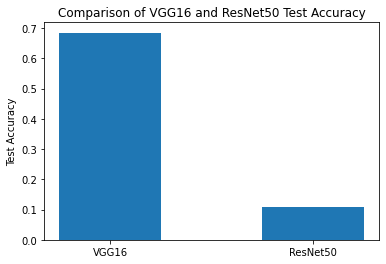

In [ ]:
accuracies = [loss_and_metrics_vgg[1],loss_and_metrics_res[1]]
plt.bar(["VGG16","ResNet50"], accuracies,  width=0.5) 

plt.ylabel("Test Accuracy") 
plt.title("Comparison of VGG16 and ResNet50 Test Accuracy") 
plt.show()

☞VGG16과 ResNet50을 비교해본 결과, VGG16에서 성능이 더 뛰어남

☞따라서 VGG16모델을 기반으로 모델을 구축

# VGG16모델 구축

In [ ]:
# Model_A와 Model_B의 구조를 함수로 구현
def getVGG16Model(lastFourTrainable=False):
  vgg_model = VGG16(weights='imagenet', input_shape=input_shape, include_top=False)

  # vgg_model의 weigth freezing
  for layer in vgg_model.layers[:]:
      layer.trainable = False

  # vgg_model + add.layer
  output = vgg_model.get_layer('block5_pool').output
  output = Flatten(name='new_flatten')(output)
  output = Dense(units=4096, activation='relu', name='fc1')(output)
  output = Dense(units=1024, activation='relu', name='fc2')(output)
  output = Dense(units=28, activation='softmax',)(output)
  vgg_model = Model(vgg_model.input, output)

  # last 3 layer(block5_conv) trainable == False -> Model_A
  # last 3 layer(block5_conv) trainable == True -> Model_B
  if lastFourTrainable == True:
    vgg_model.get_layer('block5_conv1').trainable = True
    vgg_model.get_layer('block5_conv2').trainable = True
    vgg_model.get_layer('block5_conv3').trainable = True

  # Compile VGG-16 model
  vgg_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  vgg_model.summary()

  return vgg_model



In [ ]:
def trainModel(model):
  # Fit the model
  history = model.fit_generator(train_generator,
                      epochs=epochs,
                      steps_per_epoch=num_of_train_samples // batch_size,
                      validation_data=valid_generator,
                      validation_steps=num_of_valid_samples // batch_size)

  # Evaluate the model
  loss_and_metrics = model.evaluate_generator(test_generator, steps=num_of_test_samples // batch_size+1)
  print("Test Loss: ", loss_and_metrics[0])
  print("Test Accuracy: ", loss_and_metrics[1])
  test_generator.reset()

  return model,history

## Model A (VGG16 + Finetuning X)

><img src="http://drive.google.com/uc?id=17XhhmdjYJHXqg2mENSIgqfPewLfccRg3"
width="550" height="150">



In [ ]:
# Get VGG-16 Model_A with lastFourTrainable=False
vgg_model_A = getVGG16Model(lastFourTrainable=False)
# Train VGG-16 Model_A 
vgg_model_A,history_A = trainModel(vgg_model_A)
vgg_model_A.save_weights('/content/gdrive/My Drive/deeplearning/project/model_vgg_A.h5')




58900480/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
55/55 [==============================] - ETA: 0s - loss: 12.0184 - accuracy: 0.0587

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:2800: DecompressionBombWarning: Image size (126387000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


55/55 [==============================] - 402s 7s/step - loss: 11.9235 - accuracy: 0.0597 - val_loss: 2.3236 - val_accuracy: 0.3507
Epoch 2/20
55/55 [==============================] - 35s 641ms/step - loss: 2.1933 - accuracy: 0.3698 - val_loss: 1.6867 - val_accuracy: 0.5278
Epoch 3/20
55/55 [==============================] - 35s 640ms/step - loss: 1.6091 - accuracy: 0.4995 - val_loss: 1.4802 - val_accuracy: 0.5660
Epoch 4/20
55/55 [==============================] - 35s 647ms/step - loss: 1.2199 - accuracy: 0.6255 - val_loss: 1.3716 - val_accuracy: 0.5729
Epoch 5/20
55/55 [==============================] - 35s 639ms/step - loss: 0.8541 - accuracy: 0.7417 - val_loss: 1.1596 - val_accuracy: 0.6319
Epoch 6/20
55/55 [==============================] - 35s 640ms/step - loss: 0.9810 - accuracy: 0.6759 - val_loss: 1.2335 - val_accuracy: 0.6007
Epoch 7/20
55/55 [==============================] - 35s 643ms/step - loss: 0.8584 - accuracy: 0.7295 - val_loss: 1.1504 - val_accuracy: 0.6632
Epoch 8/20


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1948: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Test Loss:  1.2026755809783936
Test Accuracy:  0.7226027250289917


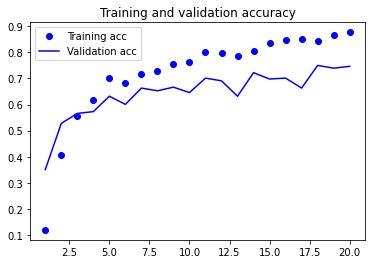

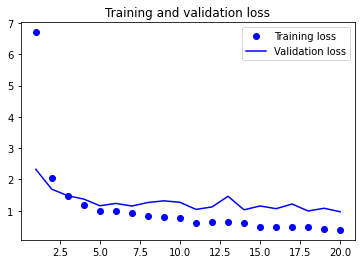

In [ ]:
# Model_A : train data와 validation data 성능 시각화
acc_A = history_A.history['accuracy'] 
val_acc_A = history_A.history['val_accuracy'] 
loss_A = history_A.history['loss'] 
val_loss_A = history_A.history['val_loss']

epochs_A = range(1, len(acc) + 1)

plt.plot(epochs_A, acc, 'bo', label='Training acc') 
plt.plot(epochs_A, val_acc, 'b', label='Validation acc') 
plt.title('Training and validation accuracy') 
plt.legend()

plt.figure()

plt.plot(epochs_A, loss, 'bo', label='Training loss') 
plt.plot(epochs_A, val_loss, 'b', label='Validation loss') 
plt.title('Training and validation loss') 
plt.legend()

plt.show()

## Model B (VGG16 + Finetuning O)

><img src="http://drive.google.com/uc?id=1grGhkXjRq18hu0jaN8BNT5Ablo-kDMOc"
width="550" height="150">


In [ ]:
# Get VGG-16 Model_B with lastFourTrainable=True
vgg_model_B = getVGG16Model(lastFourTrainable=True)
# Train VGG-16 Model_B
vgg_model_B, history_B = trainModel(vgg_model_B)
vgg_model_B.save_weights('/content/gdrive/My Drive/deeplearning/project/model_vgg_B.h5')

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
55/55 [==============================] - ETA: 0s - loss: 4.8803 - accuracy: 0.0350

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:2800: DecompressionBombWarning: Image size (126387000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


55/55 [==============================] - 38s 650ms/step - loss: 4.8622 - accuracy: 0.0349 - val_loss: 3.3280 - val_accuracy: 0.0417
Epoch 2/20
55/55 [==============================] - 35s 650ms/step - loss: 3.3280 - accuracy: 0.0333 - val_loss: 3.3212 - val_accuracy: 0.0451
Epoch 3/20
55/55 [==============================] - 35s 645ms/step - loss: 3.3220 - accuracy: 0.0462 - val_loss: 3.3129 - val_accuracy: 0.0486
Epoch 4/20
55/55 [==============================] - 36s 658ms/step - loss: 3.3124 - accuracy: 0.0481 - val_loss: 3.3105 - val_accuracy: 0.0486
Epoch 5/20
55/55 [==============================] - 35s 638ms/step - loss: 3.3142 - accuracy: 0.0537 - val_loss: 3.3109 - val_accuracy: 0.0486
Epoch 6/20
55/55 [==============================] - 35s 645ms/step - loss: 3.3160 - accuracy: 0.0405 - val_loss: 3.3091 - val_accuracy: 0.0486
Epoch 7/20
55/55 [==============================] - 36s 650ms/step - loss: 3.3180 - accuracy: 0.0520 - val_loss: 3.3106 - val_accuracy: 0.0486
Epoch 8/20

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1948: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Test Loss:  3.3100922107696533
Test Accuracy:  0.04794520512223244


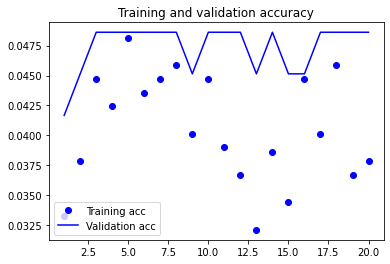

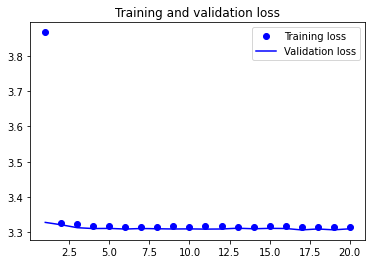

In [ ]:
# Model_B : train data와 validation data 성능 시각화
acc_B = history_B.history['accuracy'] 
val_acc_B = history_B.history['val_accuracy'] 
loss_B = history_B.history['loss'] 
val_loss_B = history_B.history['val_loss']

epochs_B = range(1, len(acc) + 1)

plt.plot(epochs_B, acc, 'bo', label='Training acc') 
plt.plot(epochs_B, val_acc, 'b', label='Validation acc') 
plt.title('Training and validation accuracy') 
plt.legend()

plt.figure()

plt.plot(epochs_B, loss, 'bo', label='Training loss') 
plt.plot(epochs_B, val_loss, 'b', label='Validation loss') 
plt.title('Training and validation loss') 
plt.legend()

plt.show()

## Model C (VGG16 + GAP)

><img src="http://drive.google.com/uc?id=1QWBJk5abcyYhxfopocqiRDBtyOYyr3qp"
width="550" height="150">


In [ ]:
# Model_C의 구조를 함수로 구현
def getVGG16Model_GAP():
  vgg_model = VGG16(weights='imagenet', input_shape=input_shape, include_top=False)

  # vgg_model의 weigth freezing
  for layer in vgg_model.layers[:]:
      layer.trainable = False

  # vgg_model + add.layer
  output = vgg_model.get_layer('block5_conv3').output
  output = Conv2D(filters=1024, kernel_size=(3, 3), padding = 'same',activation='relu',name='new_con')(output) 
  output = GlobalAveragePooling2D(name='GAP')(output)
  output = Dense(1024, activation='relu',name='dense')(output) 
  output = Dense(28, activation='softmax',name='dense_2')(output) 
  vgg_model = Model(vgg_model.input, output)


  # Compile VGG-16 model
  vgg_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  vgg_model.summary()

  return vgg_model


In [ ]:
# Get VGG-16 Model_C
vgg_model_C = getVGG16Model_GAP
# Train VGG-16 Model_C 
vgg_model_C,history_C = trainModel(vgg_model_C)
vgg_model_C.save_weights('/content/gdrive/My Drive/deeplearning/project/model_vgg_C.h5')

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
55/55 [==============================] - ETA: 0s - loss: 3.4169 - accuracy: 0.0725

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:2800: DecompressionBombWarning: Image size (126387000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


55/55 [==============================] - 39s 692ms/step - loss: 3.4121 - accuracy: 0.0734 - val_loss: 2.6508 - val_accuracy: 0.1944
Epoch 2/20
55/55 [==============================] - 35s 631ms/step - loss: 2.3870 - accuracy: 0.2563 - val_loss: 1.7751 - val_accuracy: 0.4444
Epoch 3/20
55/55 [==============================] - 35s 637ms/step - loss: 1.6992 - accuracy: 0.4764 - val_loss: 1.5986 - val_accuracy: 0.5382
Epoch 4/20
55/55 [==============================] - 35s 624ms/step - loss: 1.3843 - accuracy: 0.5615 - val_loss: 1.4332 - val_accuracy: 0.5694
Epoch 5/20
55/55 [==============================] - 35s 639ms/step - loss: 1.1878 - accuracy: 0.6462 - val_loss: 1.3195 - val_accuracy: 0.5833
Epoch 6/20
55/55 [==============================] - 35s 631ms/step - loss: 0.9743 - accuracy: 0.7102 - val_loss: 1.2614 - val_accuracy: 0.6076
Epoch 7/20
55/55 [==============================] - 35s 627ms/step - loss: 0.9661 - accuracy: 0.6959 - val_loss: 1.0706 - val_accuracy: 0.6597
Epoch 8/20

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1948: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Test Loss:  1.2539275884628296
Test Accuracy:  0.7191780805587769


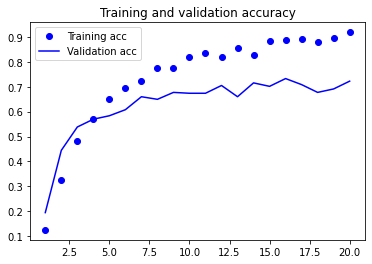

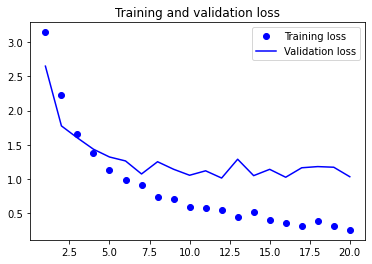

In [ ]:
# Model_C : train data와 validation data 성능 시각화
acc_C = history_C.history['accuracy'] 
val_acc_C = history_C.history['val_accuracy'] 
loss_C = history_C.history['loss'] 
val_loss_C = history_C.history['val_loss']

epochs_C = range(1, len(acc) + 1)

plt.plot(epochs_C, acc, 'bo', label='Training acc') 
plt.plot(epochs_C, val_acc, 'b', label='Validation acc') 
plt.title('Training and validation accuracy') 
plt.legend()

plt.figure()

plt.plot(epochs_C, loss, 'bo', label='Training loss') 
plt.plot(epochs_C, val_loss, 'b', label='Validation loss') 
plt.title('Training and validation loss') 
plt.legend()

plt.show()

## Model D (VGG16 + Dropout)

><img src="http://drive.google.com/uc?id=1_T1KOJfljcmC3o4IF8UrHk_2bTY7Y2tq"
width="550" height="150">

In [ ]:
# Model_D의 구조를 함수로 구현
def getVGG16Model_Dropout():
  vgg_model = VGG16(weights='imagenet', input_shape=input_shape, include_top=False)

  # vgg_model의 weigth freezing
  for layer in vgg_model.layers[:]:
      layer.trainable = False
      
  # vgg_model + add.layer
  output = vgg_model.get_layer('block5_pool').output
  output = Flatten(name='new_flatten')(output)
  output = Dense(units=4096, activation='relu', name='fc1')(output)
  output = Dropout(0.5)(output)
  output = Dense(units=1024, activation='relu', name='fc2')(output)
  output = Dense(units=28, activation='softmax',)(output)
  vgg_model = Model(vgg_model.input, output)


  # Compile VGG-16 model
  vgg_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  vgg_model.summary()

  return vgg_model

In [ ]:
# Get VGG-16 Model_D
vgg_model_D = getVGG16Model_Dropout()
# Train VGG-16 Model_D 
vgg_model_D,history_D = trainModel(vgg_model_D)
vgg_model_D.save_weights('/content/gdrive/My Drive/deeplearning/project/model_vgg_D.h5')

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
55/55 [==============================] - ETA: 0s - loss: 13.5119 - accuracy: 0.0396

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:2800: DecompressionBombWarning: Image size (126387000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


55/55 [==============================] - 38s 662ms/step - loss: 13.4098 - accuracy: 0.0402 - val_loss: 2.9361 - val_accuracy: 0.1806
Epoch 2/20
55/55 [==============================] - 35s 646ms/step - loss: 2.8539 - accuracy: 0.1821 - val_loss: 2.3237 - val_accuracy: 0.3090
Epoch 3/20
55/55 [==============================] - 35s 643ms/step - loss: 2.3909 - accuracy: 0.3082 - val_loss: 1.8768 - val_accuracy: 0.4132
Epoch 4/20
55/55 [==============================] - 35s 645ms/step - loss: 2.2586 - accuracy: 0.3362 - val_loss: 1.5798 - val_accuracy: 0.5660
Epoch 5/20
55/55 [==============================] - 35s 635ms/step - loss: 1.9072 - accuracy: 0.4235 - val_loss: 1.5663 - val_accuracy: 0.5035
Epoch 6/20
55/55 [==============================] - 35s 635ms/step - loss: 1.8460 - accuracy: 0.4355 - val_loss: 1.3646 - val_accuracy: 0.6007
Epoch 7/20
55/55 [==============================] - 35s 633ms/step - loss: 1.7820 - accuracy: 0.4582 - val_loss: 1.5318 - val_accuracy: 0.5556
Epoch 8/2

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1948: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Test Loss:  1.2828311920166016
Test Accuracy:  0.6198630332946777


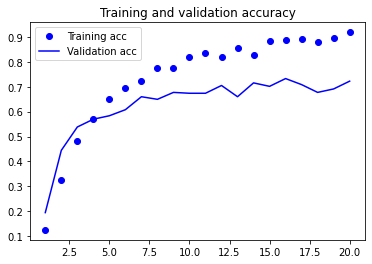

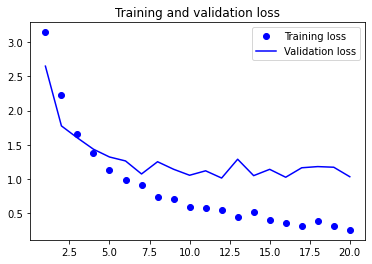

In [ ]:
# Model_D : train data와 validation data 성능 시각화
acc_D = history_D.history['accuracy'] 
val_acc_D = history_D.history['val_accuracy'] 
loss_D = history_D.history['loss'] 
val_loss_D = history_D.history['val_loss']

epochs_D = range(1, len(acc) + 1)

plt.plot(epochs_D, acc, 'bo', label='Training acc') 
plt.plot(epochs_D, val_acc, 'b', label='Validation acc') 
plt.title('Training and validation accuracy') 
plt.legend()

plt.figure()

plt.plot(epochs_D, loss, 'bo', label='Training loss') 
plt.plot(epochs_D, val_loss, 'b', label='Validation loss') 
plt.title('Training and validation loss') 
plt.legend()

plt.show()

# 정확도 비교

*  Model A,B,C,D 에 대하여 각각 train accuracy와 validation accuracy 비교

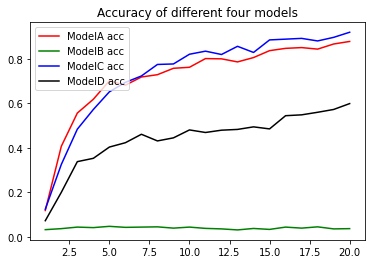

In [ ]:
# Model_A~D : Training accuracy 시각화
acc_A = history_A.history['accuracy'] 
acc_B = history_B.history['accuracy']
acc_C = history_C.history['accuracy']
acc_D = history_D.history['accuracy']

epochs_E = range(1, 21)

# Model_A, Model_C : Good
# Model_B : Bad
plt.plot(epochs_E, acc_A, 'r', label='ModelA acc') 
plt.plot(epochs_E, acc_B, 'g', label='ModelB acc')
plt.plot(epochs_E, acc_C, 'b', label='ModelC acc') 
plt.plot(epochs_E, acc_D, 'k', label='ModelD acc')  
plt.title('Accuracy of different four models') 
plt.legend()
plt.show()

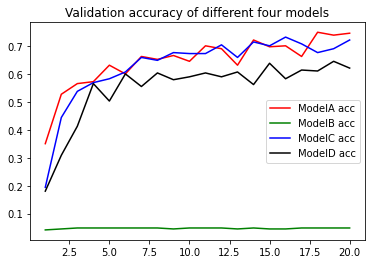

In [ ]:
# Model_A~D : Validation accuracy 시각화
val_acc_A = history_A.history['val_accuracy'] 
val_acc_B = history_B.history['val_accuracy']
val_acc_C = history_C.history['val_accuracy']
val_acc_D = history_D.history['val_accuracy']

epochs_F = range(1, 21)

# Model_B : So Bad
plt.plot(epochs_F, val_acc_A, 'r', label='ModelA acc') 
plt.plot(epochs_F, val_acc_B, 'g', label='ModelB acc')
plt.plot(epochs_F, val_acc_C, 'b', label='ModelC acc') 
plt.plot(epochs_F, val_acc_D, 'k', label='ModelD acc')  
plt.title('Validation accuracy of different four models') 
plt.legend()
plt.show()

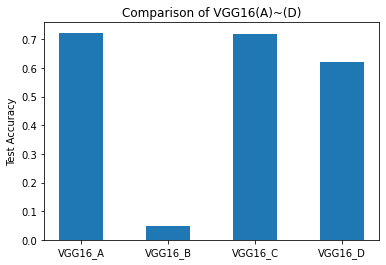

In [ ]:
# 4개 model : Test accuracy 시각화
all_accuracies = [0.7226027250289917,0.04794520512223244,0.7191780805587769,0.6198630332946777]
plt.bar(["VGG16_A","VGG16_B","VGG16_C","VGG16_D"], all_accuracies,  width=0.5) 

plt.ylabel("Test Accuracy") 
plt.title("Comparison of VGG16(A)~(D)") 
plt.show()

# 이미지 검색

* **성능이 좋았던 Model_A와 Model_C를 사용**

In [ ]:
# 학습된 model을 사용해 입력된 image의 feature를 추출
def getFeatureVector(model, img_path):
  img = cv2.imread(img_path)
  img = cv2.resize(img, (224, 224))
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  feature_vector = model.predict(img.reshape(1, 224, 224, 3))
  return feature_vector


# 국내 이미지(train data)와 해외 이미지(new data)의 feature vector를 사용해 코사인 유사도 계산
def getCosineSimilarity(A, B):
  cos_similarity = np.dot(A,B.T) / (np.linalg.norm(A)*np.linalg.norm(B)) # Get cosine similarity
  return cos_similarity[0][0]


# getFeatureVector를 통해 추출한 feature를 dataframe으로 만들기
def getFeatureDataFrame(model):
  df = pd.DataFrame(columns=['file', 'features'])
  train_files = train_generator.filepaths
  valid_files = valid_generator.filepaths
  files = train_files + valid_files

  df['file'] = files
  df['features'] = df.apply(lambda row: getFeatureVector(model, row['file']), axis=1) 

  print("All files added.")
  return df

# 입력한 해외 이미지와 코사인 유사도가 높은 상위 5개의 국내 이미지를 플로팅
def plotSimilarImages(img_file, similar_df, model_name):
  img = cv2.imread(img_file)
  img = cv2.resize(img, (224, 224))
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  split_list = img_file.split('/')
  split_list.reverse()
  img_class = split_list[1]
  fig, axarr = plt.subplots(2,3)
  axarr[0,0].imshow(img)
  axarr[0,0].set_title("TEST IMAGE - " + model_name + "\nClass: " + img_class)
  axarr[0,0].axis('off')


  j, k, m = 0, 0, 1
  for index, sim in similar_df.iterrows():
    filepath = sim['file']
    similarity = sim['similarity']
    split_list = filepath.split('/')
    split_list.reverse()
    sim_class = split_list[1]

    similar = cv2.imread(filepath)
    similar = cv2.resize(similar, (224, 224))
    similar = cv2.cvtColor(similar, cv2.COLOR_BGR2RGB)
    axarr[k,m].imshow(similar)
    axarr[k,m].set_title("Similarity: %.3f" % similarity + "\n" + sim_class)
    axarr[k,m].axis('off')

    m += 1
    if m == 3 and k != 1:
      k += 1
      m = 0

    j += 1
    if j == 5:
      break

  plt.tight_layout()
  plt.show()


# 이전 3개의 함수를 통합하는 함수
def getSimilarImages(img_file, features_df, model, model_name):
  img_features = getFeatureVector(model, img_file)
  features_df['similarity'] = features_df.apply(lambda row: getCosineSimilarity(img_features, np.asarray(row['features'])), axis=1)  
  sorted_df = features_df.sort_values(by='similarity', ascending=False)  
  plotSimilarImages(img_file, sorted_df.head(5), model_name) #head(5)를 조절하여 순위 결정

In [ ]:
# Model_A 불러오기
vgg_model_A = getVGG16Model(lastFourTrainable=False)
vgg_model_A.load_weights('/content/gdrive/My Drive/deeplearning/project/model_vgg_A.h5')
feature_model_vgg_A = Model(inputs=vgg_model_A.input, outputs=vgg_model_A.get_layer('fc1').output)

# dataframe을 pickle로 저장
df = getFeatureDataFrame(feature_model_vgg_A)
df.to_pickle("/content/gdrive/My Drive/deeplearning/project/features_vgg_A.pickle")


Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [ ]:
# Model_C 불러오기
vgg_model_C = getVGG16Model_GAP()
vgg_model_C.load_weights('/content/gdrive/My Drive/deeplearning/project/model_vgg_C.h5')
feature_model_vgg_C = Model(inputs=vgg_model_C.input, outputs=vgg_model_C.get_layer('dense').output)

# dataframe을 pickle로 저장
df = getFeatureDataFrame(feature_model_vgg_C)
df.to_pickle("/content/gdrive/My Drive/deeplearning/project/features_vgg_C.pickle")

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [ ]:
# Test images(해외 이미지) path
feature_test_path = '/content/gdrive/My Drive/deeplearning/project/feature_test'
feature_test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(directory=feature_test_path,
                                                                  class_mode='categorical',
                                                                  batch_size=batch_size,
                                                                  target_size=(img_rows, img_cols),
                                                                  color_mode="rgb",
                                                                  shuffle=False)
feature_test_files = feature_test_generator.filepaths

Found 6 images belonging to 6 classes.


## 이미지 검색 결과

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0  

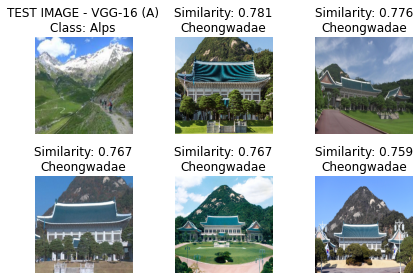

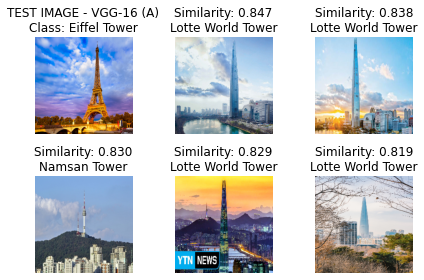

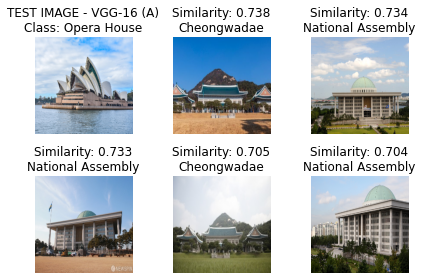

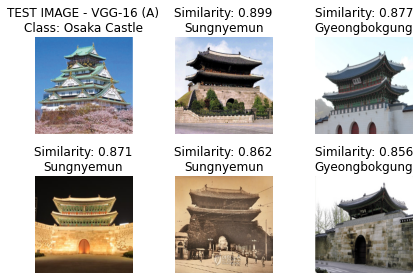

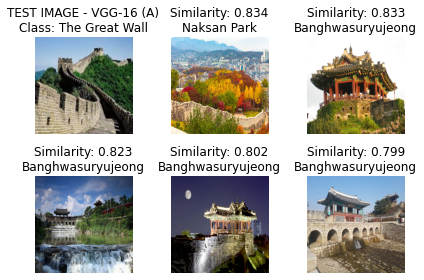

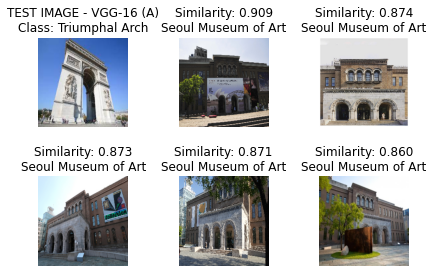

In [ ]:
# Model_A를 이용해서 해외 이미지와 유사한 국내 이미지 가져오기

vgg_model_A = getVGG16Model(lastFourTrainable=False)
vgg_model_A.load_weights('/content/gdrive/My Drive/deeplearning/project/model_vgg_A.h5')
feature_model_vgg_A = Model(inputs=vgg_model_A.input, outputs=vgg_model_A.get_layer('fc1').output)

df = pd.read_pickle('/content/gdrive/My Drive/deeplearning/project/features_vgg_A.pickle')


for file in feature_test_files:
  getSimilarImages(file, df, feature_model_vgg_A, 'VGG-16 (A)')



Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0  

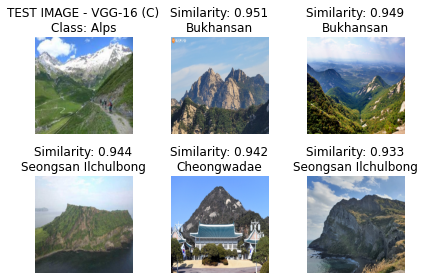

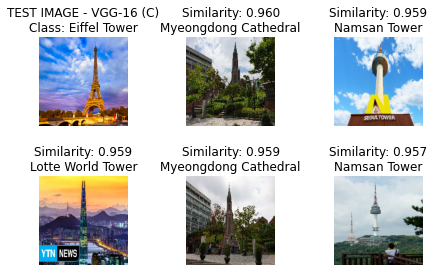

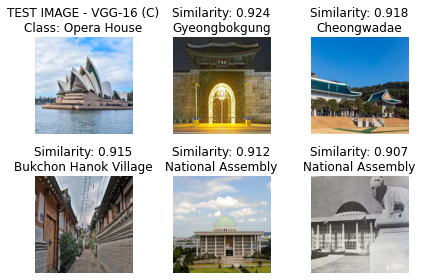

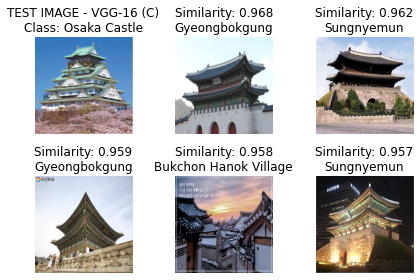

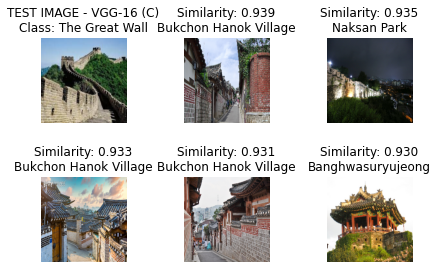

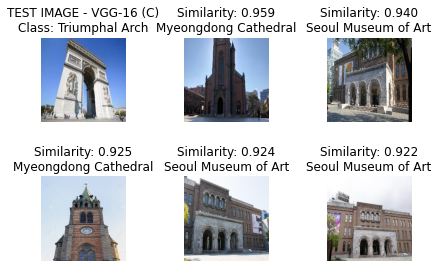

In [ ]:
# Model_C를 이용해서 해외 이미지와 유사한 국내 이미지 가져오기

vgg_model_C = getVGG16Model_GAP()
vgg_model_C.load_weights('/content/gdrive/My Drive/deeplearning/project/model_vgg_C.h5')
feature_model_vgg_C = Model(inputs=vgg_model_C.input, outputs=vgg_model_C.get_layer('dense').output)

df = pd.read_pickle('/content/gdrive/My Drive/deeplearning/project/features_vgg_C.pickle')


for file in feature_test_files:
  getSimilarImages(file, df, feature_model_vgg_C, 'VGG-16 (C)')

# 한계점

시각적인 분위기만 고려하기 때문에 실제 여행지와 성격이 다를 수 있음  
ex)오페라하우스와 비슷한 상위 국내 여행지 : 국회의사당, 청와대

# Reference


* VGG16(C) - GlobalAveragePooling 참고 : https://jsideas.net/class_activation_map/
* cosine-similarity를 이용한 Image Retrieval : https://medium.com/analytics-vidhya/cnn-transfer-learning-with-vgg-16-and-resnet-50-feature-extraction-for-image-retrieval-with-keras-53320c580853